In [28]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
import sys
sys.path.append("../")
import read_mist_models
from matplotlib import colors
from scipy.interpolate import interp1d
import utils
from astropy.coordinates import SkyCoord
from astropy import units as u
import gyrochrones as gyr

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', handlelength=10)
pl.rc('legend', fontsize=20)

%matplotlib inline

#### Load in output from round.py and crossmatch with k2dr2 table from Bailer-Jones et al

In [21]:
data = utils.read_round("../output/out.dat")
k2dr2 = Table.read('../k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic_number')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Read in mist isochrone (for picking main sequence) and parsec isochrones (for converting from gaia mags to Johnson mags)

In [22]:
iso = read_mist_models.ISOCMD('../MIST_iso_5da0dbfba0a60.iso.cmd')
mist = iso.isocmds[iso.age_index(9.0)]
isonames1 = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')
parsec1 = pd.read_table('../output783328222883.dat', delim_whitespace=True, header=None, comment='#', names=isonames1)
isonames2 = ('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 
             'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
             'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag')
parsec2 = pd.read_table('../output632510793236.dat', delim_whitespace=True, header=None, comment='#', names=isonames2)
iok = np.where((parsec1['label'] < 2) & (parsec1['Gmag'] > 1.7))[0][::-1]

Reading in: ../MIST_iso_5da0dbfba0a60.iso.cmd


#### Select stars with good gaia solutions

In [23]:
# select stars with good gaia results 

good_parallax = df["parallax_error"] < 0.1
unimodal_distance_result = (df["r_modality_flag"] == 1) & (df["r_result_flag"] == 1)
has_finite_bp_rp = np.isfinite(df["bp_rp"])
good_bp = df["phot_bp_mean_flux_error"]/df[u'phot_bp_mean_flux'] < 0.01
good_rp = df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01
good_mg = df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01
in_r_range = (df["r_est"] > 0) & (df["r_est"] < 500)
mask = good_parallax & unimodal_distance_result & has_finite_bp_rp & good_bp & good_rp & good_mg & in_r_range

#### Interpolate from Gaia GP-RP color to Johnson B-V color

In [24]:
iso_bp_rp = mist['Gaia_BP_MAWb'] - mist['Gaia_RP_MAW']
iso_mg = mist['Gaia_G_MAW']
mass_mask = (mist['initial_mass'] < 2.0) & (mist['initial_mass'] > 0.2)
iso_bp_rp = iso_bp_rp[mass_mask]
iso_mg = iso_mg[mass_mask]

in_color_range = (df["bp_rp"] > min(iso_bp_rp)) & (df["bp_rp"] < max(iso_bp_rp))
mask = mask & in_color_range

interpolator = interp1d(iso_bp_rp, iso_mg)
iso_mg_interp = interpolator(df[mask]['bp_rp'])

#### Select main sequence

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


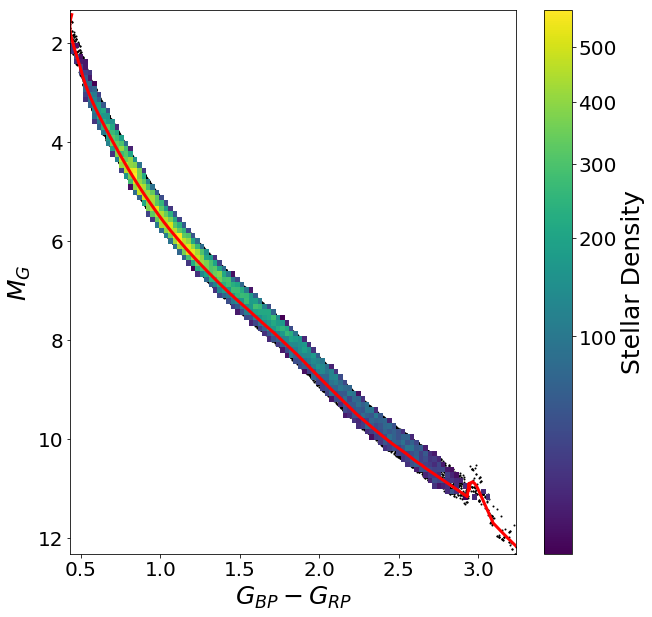

In [25]:
correction = 5*np.log10(df[mask]["r_est"])-5 # get absolute mag Mg from relative mg by applying distance correction 
bp_rp, mg = np.array(df[mask]["bp_rp"]), np.array(df[mask]["phot_g_mean_mag"])-correction
is_ms = (mg - iso_mg_interp < 0.2) & (iso_mg_interp - mg < 0.4)

fig, ax = pl.subplots(figsize=(10, 10))

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[is_ms], mg[is_ms], bins=100, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter
ax.scatter(bp_rp[is_ms], mg[is_ms], alpha=1, s=1, color='k', zorder=0)
ax.plot(iso_bp_rp, iso_mg, 'r', linewidth=3) 
ax.invert_yaxis()
cb = fig.colorbar(h[3])
ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$M_G$')
cb.set_label("Stellar Density")
pl.show()

#### Plot period vs. Gaia color

In [14]:
relative_uncertainty = df['logperiod_sd']/df['logperiod_mean']
snr = df['logamp_mean']-df['logs2_mean']
nobeehive = (df['k2_campaign_str'] != b'5') & (df['k2_campaign_str'] != b'16')
good_period = ((df['logperiod_neff'] > 7000) & 
               (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1) & 
               (relative_uncertainty < 0.1) & (np.exp(df['logperiod_mean']) < 33) &
               (snr > np.log(10)))

df_good = df[mask & is_ms & good_period]

period = np.exp(df_good['logperiod_mean'])
logperiod_error = df_good['logperiod_sd']
logperiod = df_good['logperiod_mean']
color = df_good['bp_rp']

#### Convert Gaia colors to B-V 

In [19]:
period = np.exp(df_good['logperiod_mean'])
BV_ms = np.interp(df_good['bp_rp'], parsec1['G_BPmag'][iok] - parsec1['G_RPmag'][iok],
                 parsec2['Bmag'][iok] - parsec2['Vmag'][iok])
df_good['B_V'] = BV_ms

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Fine a good isochrone for separating modalities

/Users/tgordon/research/round/round/gyrochrones.py:16: RuntimeWarning: invalid value encountered in power
  P = age**0.52 * (c * (B_V - d)**f)


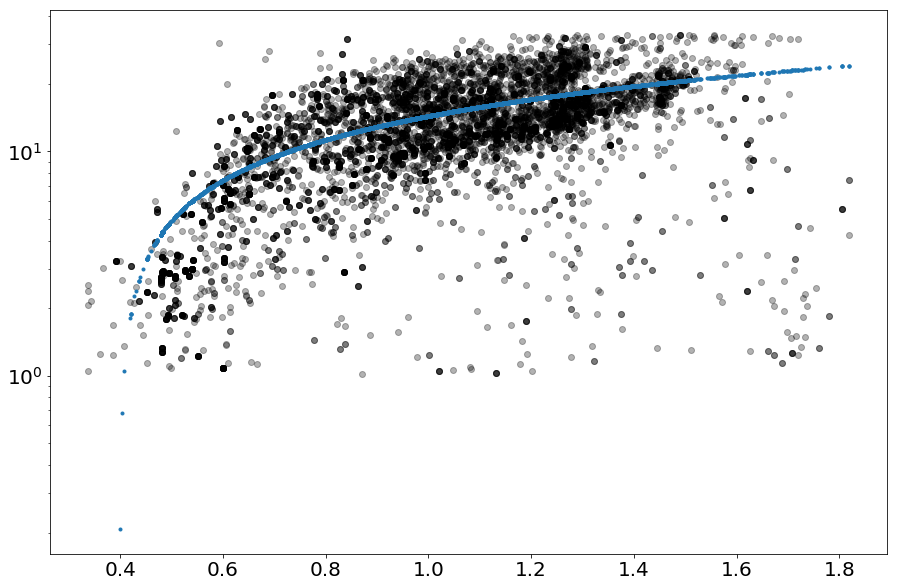

In [29]:
fig = pl.figure(figsize=(15, 10))
pl.semilogy(BV_ms, period, 'o', alpha=0.3, color='k')
pl.semilogy(BV_ms, gyr.MM09e3(BV_ms, 500), '.')

#### Plot histogram of rotation periods relative to gyrochrone

/Users/tgordon/research/round/round/gyrochrones.py:16: RuntimeWarning: invalid value encountered in power
  P = age**0.52 * (c * (B_V - d)**f)


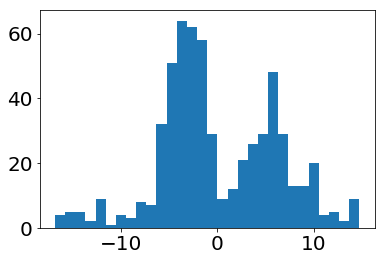

In [30]:
BV_mask = (BV_ms > 1.25) & (BV_ms < 1.3)
pl.hist(period[BV_mask] - gyr.MM09e3(BV_ms, 500)[BV_mask], bins=30);

#### Use Gaia to find galactocentric coordinates

In [31]:
ra, dec, dist = list(df_good['ra']), list(df_good['dec']), list(df_good['r_est'])
coords = [SkyCoord(ra = ra[i]*u.degree, dec = dec[i]*u.degree, distance = dist[i]*u.parsec) for i in range(len(ra))]
df_good['galcen_x'] = [c.galactocentric.x.value for c in coords]
df_good['galcen_y'] = [c.galactocentric.y.value for c in coords]
df_good['galcen_z'] = [c.galactocentric.z.value for c in coords]

#### Plot stars in galactocentric coordinates

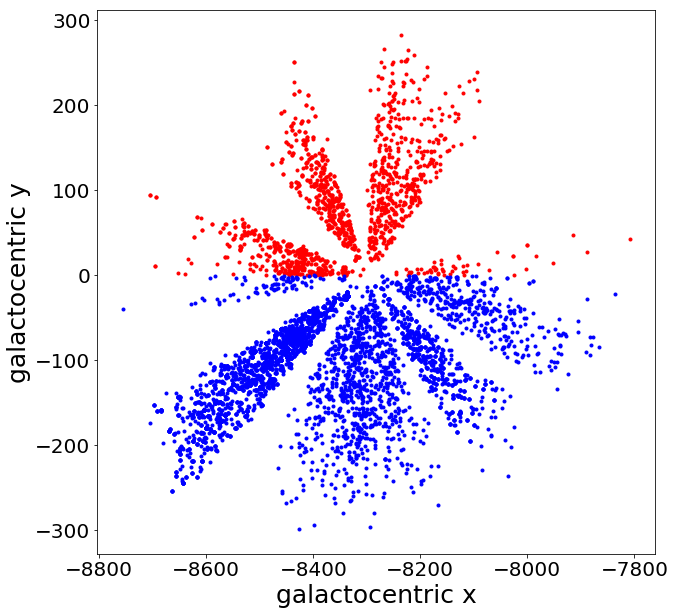

In [32]:
pl.figure(figsize=(10, 10))
pl.plot(df_good['galcen_x'][df_good['galcen_y'] > 0], df_good['galcen_y'][df_good['galcen_y'] > 0], 'r.')
pl.plot(df_good['galcen_x'][df_good['galcen_y'] < 0], df_good['galcen_y'][df_good['galcen_y'] < 0], 'b.')
pl.xlabel("galactocentric x")
pl.ylabel("galactocentric y")
pl.savefig("../figures/position.pdf")

### Save selected stars to an hdf5 file 

In [34]:
df_good.to_hdf('data/good.h5', key='df', mode='w')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->bytes,key->block6_values] [items->['designation', 'phot_variable_flag', 'datalink_url', 'epoch_photometry_url', 'tm_name', 'k2_campaign_str', 'k2_type', 'k2_kepmagflag', 'k2c_disp', 'k2c_note']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [ ]:
xcoord = df_good['galcen_x'] + 8300
ycoord = df_good['galcen_y']
angle = np.arctan(ycoord/xcoord)*180/np.pi
forward = (np.abs(angle) > 60) & (ycoord > 0)
backward = (np.abs(angle) > 60) & (ycoord < 0)

pl.figure(figsize=(10, 10))
pl.plot(df_good['galcen_x'], df_good['galcen_y'], 'k.')
pl.plot(df_good['galcen_x'][forward], df_good['galcen_y'][forward], 'r.')
pl.plot(df_good['galcen_x'][backward], df_good['galcen_y'][backward], 'b.')
pl.xlabel("galactocentric x")
pl.ylabel("galactocentric y")

#### Plot period-color diagram separated by direction 

In [ ]:
fig = pl.figure(figsize=(15, 10))

pl.semilogy(color_good[forward], period_good[forward], 'o', alpha=0.3, color='b', label="y < 0")

pl.semilogy(color_good[backward], period_good[backward], 'o', alpha=0.3, color='r', label="y > 0")
pl.xlabel(r"$\mathrm{G}_\mathrm{GP}-\mathrm{G}_\mathrm{RP}$ (mag)")
pl.ylabel("rotation period (days)")
leg = pl.legend(loc='lower right')
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(10)
leg.get_frame().set_linewidth(3)
pl.savefig("../figures/period_direction.pdf")

In [ ]:
BV_mask = (BV_ms > 1.25) & (BV_ms < 1.35)
nobeehive = (df_good['k2_campaign_str'] != b'5') & (df_good['k2_campaign_str'] != b'16')
#y_mask = df_good['galcen_y'] < 0
pl.hist(period[BV_mask & forward & nobeehive] - MM09e2(BV_ms, 500)[BV_mask & forward & nobeehive & nobeehive], bins=30, alpha=0.5, color='b', density=True);

#y_mask = df_good['galcen_y'] > 0
pl.hist(period[BV_mask & backward & nobeehive] - MM09e2(BV_ms, 500)[BV_mask & backward], bins=30, alpha=0.5, color='r', density=True);